# Coding Practice 3 Graph Neural Networks (GNN)

Welcome to the Graph Neural Networks (GNN) programming assignment!

In this hands-on assignment, we'll explore the fascinating domain of graph analysis through the lens of deep learning. Graph structures are pervasive in our world, from social networks to molecular interactions. GNNs equip us with the robust tools necessary to decipher and harness these complex relationships.

By journey's end, you'll:
- Grasp the foundational concepts of GNNs,
- Understand their application in graph analysis, and
- Gain practical experience in implementing GNNs using state-of-the-art deep learning frameworks.

Dive in and let's embark on this learning adventure!


## Environment Setup

For a seamless execution of this notebook, ensure your Python environment is properly set up. Here's what you'll need:

- **Python Version**: We recommend using Python 3.8 or higher.
- **Required Packages**: Install the following libraries to delve into GNNs:
  - `torch`
  - `torch_geometric`
  - `torch_scatter`
  - `torch_sparse`
  - `torchmetrics`
  - `networkx`
  - `numpy`
  - `jupyter`

- **For Local Testing**: If you wish to visualize and run tests outside this notebook, please also install:
  - `matplotlib`


In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torchmetrics

%matplotlib inline
import matplotlib.pyplot as plt
import torch_geometric
import torch_scatter
import torch_sparse
import torchmetrics
import networkx

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 68.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 13.0 MB/s eta 0:00:00


Graph Neural Networks (GNNs) represent a compelling frontier in the deep learning landscape, specifically tailored to address the challenges of irregular structured data inherent to graphs. Their core objective? Enable neural architectures to discern not just objects, but the intricate web of relationships connecting them.

At the heart of GNNs lies the neural message-passing paradigm. Through iterative processes, node features undergo updates by accumulating insights from neighboring nodes. This tutorial endeavors to:
- Illuminate the core principles of deep learning on graph structures via GNNs,
- Showcase the power and elegance of the PyTorch Geometric (PyG) library – a robust extension of the PyTorch framework.

With PyG, you'll find GNN implementation streamlined, thanks to its myriad of utilities and methods dedicated to this very task.


We'll commence our exploration with the **CLUSTER** dataset from the GNNBenchmarkDataset, as detailed in the paper [Benchmarking Graph Neural Networks](https://arxiv.org/abs/2003.00982). This dataset is a subset of the SBM datasets, which delves into node-level graph pattern recognition tasks (as explored by Scarselli et al., 2009). Specifically, it addresses:
- Graph Pattern Recognition: **PATTERN**
- Semi-supervised Graph Clustering: **CLUSTER**.

The backbone of these datasets is the Stochastic Block Model (SBM) from Abbe (2017). A staple in the world of modeling communities within social networks, SBM fine-tunes the connections both within and outside communities. This modulation controls the intricacy of the tasks in hand. Specifically, in an SBM:
- Two vertices within the same community have a connection probability of \( p \).
- If they hail from distinct communities, the connection probability becomes \( q \) - serving as a noise level parameter.

Shedding light on the **CLUSTER** dataset's specifics:
- Each node boasts 7 features.
- Labels span across 6 classes.
- The overarching task? Multiclass classification.



In [2]:
from torch_geometric.datasets import GNNBenchmarkDataset

train_dataset = GNNBenchmarkDataset(root='data', name='CLUSTER', split='train')
val_dataset = GNNBenchmarkDataset(root='data', name='CLUSTER', split='val')

print(f'Train Dataset: {train_dataset}:')
print(f'Number of graphs: {len(train_dataset)}')
print(f'Number of features: {train_dataset.num_features}')
print(f'Number of classes: {train_dataset.num_classes}')

Extracting data/CLUSTER/raw/CLUSTER_v2.zip
Processing...
Done!


Train Dataset: CLUSTER(10000):
Number of graphs: 10000
Number of features: 7
Number of classes: 6


We can see that the train set has 10000 graphs. Every node have 7 features. We can take a close look at the first graph.

In [3]:
data = train_dataset[0]  # Get the first graph object.

print(data)

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[117, 7], edge_index=[2, 4104], y=[117])
Number of nodes: 117
Number of edges: 4104
Average node degree: 35.08
Is undirected: True


In PyTorch Geometric, the essence of a graph is encapsulated by a `Data` object, holding all salient details that define the graph. A simple `print(data)` reveals a snapshot of the object's attributes and their respective shapes. The data object predominantly comprises three attributes:

1. `edge_index`: Encapsulates graph connectivity. It's structured as a tuple where each pair captures source and destination node indices for every edge.
   
2. `x`: A matrix (or tensor) representing node features. Here, each row corresponds to a specific node, and every column delineates a feature dimension.

3. `y`: Captures node labels, assigning each node to one of the 121 available classes.

The overarching objective? Decipher the community assignment for nodes that remain unclassified.

Furthermore, the `Data` object is more than just a storage container. It offers utility functions to unveil key graph properties, like the presence of isolated nodes, self-loops, or the graph's directed/undirected nature.


In [4]:
print(data.y)

tensor([0, 3, 3, 0, 4, 3, 0, 2, 0, 0, 0, 2, 2, 0, 1, 5, 3, 0, 2, 4, 2, 3, 2, 4,
        3, 1, 3, 5, 2, 3, 0, 0, 3, 5, 2, 5, 3, 2, 0, 3, 0, 3, 3, 3, 0, 3, 2, 0,
        3, 5, 2, 4, 1, 1, 3, 4, 4, 3, 3, 3, 0, 5, 2, 4, 3, 0, 0, 4, 3, 0, 0, 1,
        4, 2, 3, 2, 0, 0, 0, 4, 2, 2, 3, 3, 3, 0, 0, 2, 2, 5, 4, 0, 2, 5, 4, 0,
        0, 2, 0, 0, 0, 3, 3, 2, 2, 1, 2, 0, 0, 0, 5, 3, 1, 4, 3, 3, 5])


For this multiclass classification, each label is represented as an integer within the range [0,5].


We can visualize the graph using networkx.

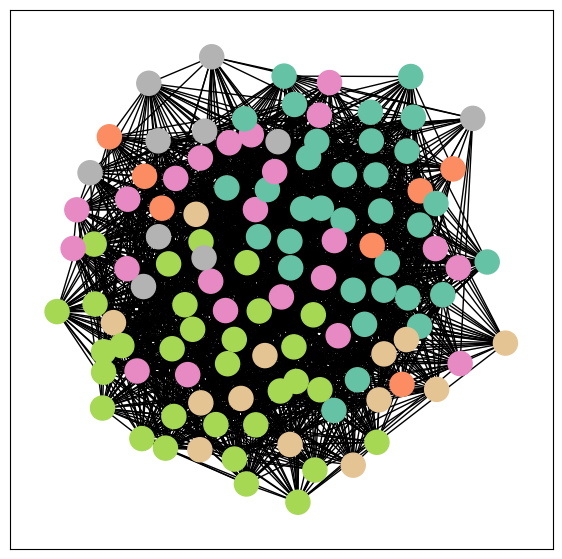

In [5]:
import networkx as nx

from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=21), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
# We random choose a class if there are more than 1 class for a data point
visualize_graph(G, color=data.y)

In certain classification tasks, the graphs are typically small. As a result, batching these graphs before processing them in a Graph Neural Network becomes crucial for optimal CPU/GPU utilization. In other domains, such as images or language, standard batching approaches involve resizing or padding each example to uniformity. These are then grouped into an additional dimension, equivalent in length to the batch size.

However, for GNNs, such methods might be impractical or result in excess memory consumption. PyTorch Geometric introduces an innovative batching approach that capitalizes on parallel processing across multiple examples. In this technique:
- Adjacency matrices of individual graphs are stacked diagonally, crafting a single graph that encompasses multiple isolated subgraphs.
- Correspondingly, node and target features undergo concatenation in the node dimension.

Adopting this approach confers distinct advantages:

1. **Unaltered Message Passing**: GNN operators leveraging message passing remain unaffected, as inter-graph node communications are non-existent.
2. **Efficiency**: Given that adjacency matrices are stored in a sparse format, only non-zero entries (the edges) are retained. This ensures minimal computational and memory overhead.

To facilitate this batching mechanism, PyTorch Geometric offers the `torch_geometric.data.DataLoader` class, seamlessly batching multiple graphs into a singular, expansive graph.


In [6]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.loader import DataLoader
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

<IPython.core.display.Javascript object>

Step 1:
Number of graphs in the current batch: 512
DataBatch(x=[60083, 7], edge_index=[2, 2205788], y=[60083], batch=[60083], ptr=[513])

Step 2:
Number of graphs in the current batch: 512
DataBatch(x=[60706, 7], edge_index=[2, 2244446], y=[60706], batch=[60706], ptr=[513])

Step 3:
Number of graphs in the current batch: 512
DataBatch(x=[59462, 7], edge_index=[2, 2159164], y=[59462], batch=[59462], ptr=[513])

Step 4:
Number of graphs in the current batch: 512
DataBatch(x=[60334, 7], edge_index=[2, 2226858], y=[60334], batch=[60334], ptr=[513])

Step 5:
Number of graphs in the current batch: 512
DataBatch(x=[59133, 7], edge_index=[2, 2140224], y=[59133], batch=[59133], ptr=[513])

Step 6:
Number of graphs in the current batch: 512
DataBatch(x=[59302, 7], edge_index=[2, 2159624], y=[59302], batch=[59302], ptr=[513])

Step 7:
Number of graphs in the current batch: 512
DataBatch(x=[60464, 7], edge_index=[2, 2241922], y=[60464], batch=[60464], ptr=[513])

Step 8:
Number of graphs in the cu

In theory, we can classify a protein solely based on its feature representation, sidestepping the need for any relational information. To validate this idea, we can construct a basic MLP that operates exclusively on input node features and employs shared weights across all nodes.


In [7]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(train_dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, train_dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
model = MLP(hidden_channels=16).to(device)
print(model)
loss_fn = torch.nn.CrossEntropyLoss()  # Define loss loss_fn.

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-6)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      for data in train_loader:
            out = model(data.x.to(device))  # Perform a single forward pass.
            loss = loss_fn(out, data.y.to(device))  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.

MLP(
  (lin1): Linear(in_features=7, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=6, bias=True)
)


## Task 1: Compute the ROC AUC Score and Weighted Accuracy [3 pts]

To gauge our model's efficacy on the CLUSTER dataset, we'll utilize two metrics: the [ROC AUC score](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) and the weighted accuracy.

**Weighted Accuracy**: This metric offers a nuanced view of the classification performance, especially in datasets where class distribution is imbalanced. It calculates accuracy for each class individually, then derives an overall accuracy score by weighting each class's accuracy by its presence (frequency) in the dataset. This ensures that performance on less frequent classes influences the final accuracy commensurate to their importance.

**ROC (Receiver Operating Characteristic) AUC (Area Under the Curve)**: A performance metric for binary classification, quantifying the area beneath the ROC curve—a plot of the True Positive Rate (TPR) against the False Positive Rate (FPR) across various classification thresholds. A flawless classifier achieves a ROC AUC score of 1, whereas a random one secures a score of 0.5.

For multiclass classification scenarios:

1. **Macro-average ROC AUC**: Independently calculates the ROC AUC for each class, then averages the scores, treating all classes uniformly, irrespective of their dataset frequency.
   
2. **Weighted-average ROC AUC**: Similar to macro-averaging, with the distinction that classes are weighted by their dataset frequency.

For our purposes, we'll employ both the weighted-average ROC AUC score and the weighted accuracy to evaluate our model's performance.

Your task: Complete the `mlp_test` function to compute both the ROC AUC score and the weighted accuracy. You can utilize `MulticlassAUROC` and `MulticlassAccuracy` from [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/) for the ROC AUC score and weighted accuracy. For weighted accuracy.


In [10]:
#export
from torchmetrics.classification import MulticlassAUROC
from torchmetrics.classification.accuracy import MulticlassAccuracy
import torch
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###

num_classes = 6

def mlp_test(model, loss_fn, loader, device):
    """
    model: pytorch GNN model
    loss_fn: loss function
    loader: DataLoader
    device: device used to bind the model and tensor
    return loss, weighted auroc, weighted accuracy
    """
    model.eval()
    total_loss = 0.0
    auroc = MulticlassAUROC(num_classes=num_classes, average='weighted').to(device)
    accuracy = MulticlassAccuracy(num_classes=num_classes, average='weighted').to(device)
    total_nodes_n = 0

    with torch.no_grad():
        for data in loader:
            data.x, data.y = data.x.to(device), data.y.to(device)
            out = model(data.x)
            loss = loss_fn(out, data.y)
            total_loss += loss.item() * data.num_graphs
            total_nodes_n += data.num_graphs

            auroc.update(out.softmax(dim=-1), data.y)
            accuracy.update(out, data.y)

    final_auroc = auroc.compute()
    final_accuracy = accuracy.compute()

    return total_loss / total_nodes_n, final_auroc, final_accuracy

In [11]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# You can tune the hyperparameters like epoch_num, learning_rate, ...
epoch_num = 30
for epoch in range(1, epoch_num):
    train()
    train_loss, train_auroc, train_acc = mlp_test(model, loss_fn, train_loader, device)
    val_loss, val_auroc, val_acc = mlp_test(model, loss_fn, val_loader, device)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Auroc: {train_auroc:.4f}, '
          f'Train Acc: {train_acc:.4f}, Valid Loss: {val_loss:.4f}, Valid Auroc: {val_auroc:.4f}, '
          f'Valid Acc: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 1.7869, Train Auroc: 0.5223, Train Acc: 0.1924, Valid Loss: 1.7872, Valid Auroc: 0.5221, Valid Acc: 0.1902
Epoch: 002, Train Loss: 1.7788, Train Auroc: 0.5369, Train Acc: 0.2008, Valid Loss: 1.7787, Valid Auroc: 0.5368, Valid Acc: 0.2011
Epoch: 003, Train Loss: 1.7674, Train Auroc: 0.5401, Train Acc: 0.2007, Valid Loss: 1.7676, Valid Auroc: 0.5400, Valid Acc: 0.1971
Epoch: 004, Train Loss: 1.7531, Train Auroc: 0.5418, Train Acc: 0.2008, Valid Loss: 1.7533, Valid Auroc: 0.5415, Valid Acc: 0.2011
Epoch: 005, Train Loss: 1.7415, Train Auroc: 0.5450, Train Acc: 0.2007, Valid Loss: 1.7418, Valid Auroc: 0.5448, Valid Acc: 0.1971
Epoch: 006, Train Loss: 1.7323, Train Auroc: 0.5466, Train Acc: 0.2093, Valid Loss: 1.7323, Valid Auroc: 0.5464, Valid Acc: 0.2096
Epoch: 007, Train Loss: 1.7224, Train Auroc: 0.5466, Train Acc: 0.2092, Valid Loss: 1.7229, Valid Auroc: 0.5464, Valid Acc: 0.2056
Epoch: 008, Train Loss: 1.7134, Train Auroc: 0.5499, Train Acc: 0.2090, Valid Loss:

While we observed a decrease in the loss, we have yet to utilize the inherent structural relationships within the graph. Clearly, we're missing out on valuable information. By effectively harnessing this pertinent data, we stand to achieve an even greater reduction in loss.


To transform our MLP into a GNN, we need to substitute the `torch.nn.Linear` layers with appropriate GNN operators from PyG. A fitting replacement for our linear layers is the `GCNConv` module from PyTorch Geometric.

The GCN layer, as introduced by Kipf et al. (2017), is mathematically represented as:

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in N(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

In this equation, $\mathbf{W}^{(\ell + 1)}$ is a trainable weight matrix of dimensions `[num_output_features, num_input_features]`. The term $c_{w,v}$ denotes a predetermined normalization coefficient for each edge. Contrastingly, a singular `Linear` layer can be described as:

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

This does not factor in information from neighboring nodes.

The rationale behind this substitution is that GNN operators are inherently designed to consider the graph's topology. By supplanting the `Linear` layers with GNN operators, we leverage information from adjacent nodes, enhancing our prediction capabilities.


## Task 2: Designing the Node Classification Model [9 pts]

Your task is to finalize the `NodeGCN` class provided. We advise leveraging the `GCNConv` module to achieve this.

To delve deeper into how various GNN layers affect model performance, consider experimenting with alternative types of layers. As a suggestion, you might replace the `GCNConv` layers with `GATConv` layers, which utilize attention mechanisms, and observe the differences in outcomes.


In [12]:
#export
from torch_geometric.nn import GCNConv

### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###
class NodeGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Finish the design of this model
        self.conv1 = GCNConv(7, 32)
        self.conv2 = GCNConv(32, 6)

    def forward(self, x, edge_index):
        # TODO: Finish this function
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        return x

######################################################################
########## DON'T WRITE ANY CODE OUTSIDE THE CLASS! ###################
######## IF YOU WANT TO CALL OR TEST IT CREATE A NEW CELL ############
######################################################################

In [13]:
model = NodeGCN().to(device)
print(model)
loss_fn = torch.nn.CrossEntropyLoss()  # Define loss loss_fn.

# You can tune the hyperparameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Define optimizer.

NodeGCN(
  (conv1): GCNConv(7, 32)
  (conv2): GCNConv(32, 6)
)


In [14]:
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      total_loss = 0.0
      for data in train_loader:
            out = model(data.x.to(device), data.edge_index.to(device))  # Perform a single forward pass.
            loss = loss_fn(out, data.y.to(device))  # Compute the loss solely based on the training nodes.
            total_loss += loss
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.

## Task 3: Finish the `gnn_test` function and compute the ROC AUC and ACC score [3 pts]

In [15]:
#export
from torchmetrics.classification import MulticlassAUROC
from torchmetrics.classification import MulticlassAccuracy
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###

def gnn_test(model, loss_fn, loader, device):
    """
    model: pytorch GNN model
    loss_fn: loss function
    loader: DataLoader
    device: device used to bind the model and tensor
    return loss, weighted auroc, weighted accuracy
    """
    model.eval()
    total_loss = 0.0
    auroc = MulticlassAUROC(num_classes=6, average='weighted').to(device)
    accuracy = MulticlassAccuracy(num_classes=6, average='weighted').to(device)

    with torch.no_grad():
        for data in loader:
            data.x, data.y = data.x.to(device), data.y.to(device)
            data.edge_index = data.edge_index.to(device)
            out = model(data.x, data.edge_index)
            loss = loss_fn(out, data.y)
            total_loss += loss.item()

            auroc.update(out.softmax(dim=-1), data.y)
            accuracy.update(out, data.y)

    final_auroc = auroc.compute()
    final_accuracy = accuracy.compute()

    return total_loss / len(loader), final_auroc, final_accuracy

In [16]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


epoch_num = 200
for epoch in range(1, epoch_num):
    train()
    train_loss, train_auroc, train_acc = gnn_test(model, loss_fn, train_loader, device)
    val_loss, val_auroc, val_acc = gnn_test(model, loss_fn, val_loader, device)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train AUROC: {train_auroc:.4f},'
    f' Train Acc: {train_acc:.4f}, Valid Loss: {val_loss:.4f}, Valid AUROC: {val_auroc:.4f}, '
    f'Valid Acc: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 1.8146, Train AUROC: 0.5023, Train Acc: 0.1668, Valid Loss: 1.8154, Valid AUROC: 0.5040, Valid Acc: 0.1648
Epoch: 002, Train Loss: 1.8127, Train AUROC: 0.5032, Train Acc: 0.1668, Valid Loss: 1.8133, Valid AUROC: 0.5048, Valid Acc: 0.1648
Epoch: 003, Train Loss: 1.8110, Train AUROC: 0.5040, Train Acc: 0.1668, Valid Loss: 1.8115, Valid AUROC: 0.5056, Valid Acc: 0.1648
Epoch: 004, Train Loss: 1.8093, Train AUROC: 0.5046, Train Acc: 0.1668, Valid Loss: 1.8099, Valid AUROC: 0.5062, Valid Acc: 0.1648
Epoch: 005, Train Loss: 1.8079, Train AUROC: 0.5053, Train Acc: 0.1668, Valid Loss: 1.8084, Valid AUROC: 0.5069, Valid Acc: 0.1648
Epoch: 006, Train Loss: 1.8067, Train AUROC: 0.5063, Train Acc: 0.1668, Valid Loss: 1.8070, Valid AUROC: 0.5079, Valid Acc: 0.1648
Epoch: 007, Train Loss: 1.8054, Train AUROC: 0.5070, Train Acc: 0.1668, Valid Loss: 1.8058, Valid AUROC: 0.5085, Valid Acc: 0.1648
Epoch: 008, Train Loss: 1.8043, Train AUROC: 0.5085, Train Acc: 0.1668, Valid Loss:

### Save the model
Save the NodeGCN model to file.

In [17]:
torch.save(model.state_dict(), "node_gcn.pth")
print("Saved PyTorch Model State to node_gcn.pth")

Saved PyTorch Model State to node_gcn.pth


In [18]:
model = NodeGCN().to(device)
model.load_state_dict(torch.load("node_gcn.pth"))
val_loss, val_auroc, val_acc = gnn_test(model, loss_fn, val_loader, device)
print("val_loss: %f, val_auroc: %f, val_acc: %f" % (val_loss, val_auroc, val_acc))

val_loss: 1.787251, val_auroc: 0.697458, val_acc: 0.332844


In [19]:
import os
print(os.getcwd())
from google.colab import files
files.download('node_gcn.pth')

/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Graph Classification

In this section, we will delve into graph classification using Graph Neural Networks (GNNs). Unlike node classification, where the focus is on individual nodes, graph classification targets the entire graph. The goal is to classify entire graphs based on their structural attributes using a dataset of various graphs. The challenge lies in effectively embedding these complete graphs to ensure they become linearly separable for the intended task.


## Graphs Derived from Images

Images can be translated into graphs, and this transformation is vividly demonstrated in the super-pixels datasets. These datasets explore graph classification using renowned image classification datasets like MNIST and CIFAR10. One of the primary motivations behind employing these datasets is to serve as benchmarking tools or sanity-checks. For instance, most GNNs are anticipated to deliver near-perfect accuracy for MNIST and respectable performance for CIFAR10. Moreover, the adaptation of super-pixel image datasets offers insights into how traditional image datasets can be repurposed for graph learning research.

In this exercise, we'll be working with the CIFAR10 super-pixels dataset for our graph classification task. Here's a brief overview: The native CIFAR10 images undergo a transformation into graphs through the use of super-pixels. Super-pixels capture small, uniform intensity regions within images. The process to extract them employs the SLIC technique, as proposed by Achanta et al. in 2012.


In [20]:
train_dataset = GNNBenchmarkDataset(root='data', name='CIFAR10', split='train')
valid_dataset = GNNBenchmarkDataset(root='data', name='CIFAR10', split='val')


print()
print(f'Train Dataset: {train_dataset}:')
print(f'Number of graphs: {len(train_dataset)}')
print(f'Number of features: {train_dataset.num_features}')
print(f'Number of classes: {train_dataset.num_classes}')

data = train_dataset[0]

print()
print(data)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/CIFAR10/raw/CIFAR10_v2.zip
Processing...
Done!



Train Dataset: CIFAR10(45000):
Number of graphs: 45000
Number of features: 3
Number of classes: 10

Data(x=[110, 3], edge_index=[2, 880], edge_attr=[880], y=[1], pos=[110, 2])
Number of nodes: 110
Number of edges: 880
Is undirected: False


In [21]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of valid graphs: {len(valid_dataset)}')

Number of training graphs: 45000
Number of valid graphs: 5000


This training dataset provides about 45000 graphs. This is a graph multiclass classfication task.

In [22]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.loader import DataLoader
batch_size=256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

<IPython.core.display.Javascript object>

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[30161, 3], edge_index=[2, 241288], edge_attr=[241288], y=[256], pos=[30161, 2], batch=[30161], ptr=[257])

Step 2:
Number of graphs in the current batch: 256
DataBatch(x=[30125, 3], edge_index=[2, 241000], edge_attr=[241000], y=[256], pos=[30125, 2], batch=[30125], ptr=[257])

Step 3:
Number of graphs in the current batch: 256
DataBatch(x=[30155, 3], edge_index=[2, 241240], edge_attr=[241240], y=[256], pos=[30155, 2], batch=[30155], ptr=[257])

Step 4:
Number of graphs in the current batch: 256
DataBatch(x=[30122, 3], edge_index=[2, 240976], edge_attr=[240976], y=[256], pos=[30122, 2], batch=[30122], ptr=[257])

Step 5:
Number of graphs in the current batch: 256
DataBatch(x=[30070, 3], edge_index=[2, 240560], edge_attr=[240560], y=[256], pos=[30070, 2], batch=[30070], ptr=[257])

Step 6:
Number of graphs in the current batch: 256
DataBatch(x=[30153, 3], edge_index=[2, 241224], edge_attr=[241224], y=[256], pos=[30153, 2], b

## Training GNNs for Graph Classification

Training a Graph Neural Network (GNN) for graph classification can be distilled into a three-tiered methodology:

1. **Node Embedding:** Through multiple iterations of message passing, every node in the graph is embedded, capturing its localized information in the context of its neighbors.

2. **Graph Embedding or Readout Layer:** Once individual node embeddings are generated, they are amalgamated into a singular graph embedding. This process, often referred to as the readout layer, effectively summarizes the entire graph's information.

3. **Graph Classification:** With the graph embedding at our disposal, the subsequent step involves training a classifier on these embeddings to determine the graph's class or label.

Among the myriad of readout layer strategies, one of the most prevalent methods is the mean aggregation of node embeddings:

$$
\mathbf{x}_{G} = \frac{1}{|V|} \sum_{v \in V} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric facilitates this process with its [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool) function. Given a set of node embeddings for every node in a mini-batch, along with the accompanying `batch` assignment vector, this utility churns out a graph embedding of dimensions `[batch_size, hidden_channels]` for each individual graph present in the batch.



## Task 4: Graph Classfication using GCNConv or GATConv [6 pts]

Your objective is to design a Graph Neural Network (GNN) model for graph classification. You have the choice of using either the GCNConv or GATConv layers as building blocks for your network.

Complete the following class structure to create your model:

In [61]:
#export
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###


class GraphConvModel(torch.nn.Module):
    def __init__(self):
        super(GraphConvModel, self).__init__()

        # TODO: Please design your MLP layers
        num_features = 3
        hidden_channels = 64
        num_classes = train_dataset.num_classes
        self.conv1 = GCNConv(3, 64)
        self.lin = Linear(64, 10)

    def forward(self, x, edge_index, batch):
        # TODO: Finish this function
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

######################################################################
########## DON'T WRITE ANY CODE OUTSIDE THE CLASS! ###################
######## IF YOU WANT TO CALL OR TEST IT CREATE A NEW CELL ############
######################################################################

In [62]:
model = GraphConvModel().to(device)
print(model)

GraphConvModel(
  (conv1): GCNConv(3, 64)
  (lin): Linear(in_features=64, out_features=10, bias=True)
)


## Task 5: Finish the `graph_test` function and compute the weighted ROC AUC score [3 pts]

In [63]:
#export
from torchmetrics.classification import MulticlassAUROC
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###

def graph_test(model, loss_fn, loader, device):
     """
      model: pytorch GNN model
      loss_fn: loss function
      loader: DataLoader
      device: device used to bind the model and tensor
      return weighted auroc
      """
     model.eval()
     auroc_score = MulticlassAUROC(num_classes=10,average='weighted').to(device)

     with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x.to(device), data.edge_index.to(device), data.batch.to(device))
            y_pred = F.softmax(out, dim=1)
            y_true = data.y

            auroc_score.update(y_pred, y_true)

     auroc_score = auroc_score.compute().item()

     return auroc_score

In [64]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

learning_rate = 1e-3
epoch_num = 30
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0.0
    for data in train_loader:
        out = model(data.x.to(device), data.edge_index.to(device), data.batch.to(device))
        # print(train_loader)
        loss = loss_fn(out, data.y.to(device))
        total_loss += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return total_loss / len(train_loader)

for epoch in range(epoch_num):
    train_loss = train()
    train_auroc = graph_test(model, loss_fn, train_loader, device)
    valid_auroc = graph_test(model, loss_fn, valid_loader, device)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.5f}, Train Auc: {train_auroc:.4f}, Valid Auc: {valid_auroc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 000, Train Loss: 2.27740, Train Auc: 0.6638, Valid Auc: 0.6668
Epoch: 001, Train Loss: 2.19985, Train Auc: 0.6671, Valid Auc: 0.6712
Epoch: 002, Train Loss: 2.14846, Train Auc: 0.6784, Valid Auc: 0.6827
Epoch: 003, Train Loss: 2.12289, Train Auc: 0.6879, Valid Auc: 0.6916
Epoch: 004, Train Loss: 2.10834, Train Auc: 0.6958, Valid Auc: 0.6993
Epoch: 005, Train Loss: 2.09841, Train Auc: 0.6999, Valid Auc: 0.7036
Epoch: 006, Train Loss: 2.09009, Train Auc: 0.7045, Valid Auc: 0.7082
Epoch: 007, Train Loss: 2.08404, Train Auc: 0.7070, Valid Auc: 0.7108
Epoch: 008, Train Loss: 2.07829, Train Auc: 0.7092, Valid Auc: 0.7131
Epoch: 009, Train Loss: 2.07327, Train Auc: 0.7105, Valid Auc: 0.7144
Epoch: 010, Train Loss: 2.06842, Train Auc: 0.7121, Valid Auc: 0.7162
Epoch: 011, Train Loss: 2.06501, Train Auc: 0.7134, Valid Auc: 0.7175
Epoch: 012, Train Loss: 2.06115, Train Auc: 0.7142, Valid Auc: 0.7184
Epoch: 013, Train Loss: 2.05788, Train Auc: 0.7151, Valid Auc: 0.7193
Epoch: 014, Train Lo

In [65]:
torch.save(model.state_dict(), "graph_gcn.pth")
print("Saved PyTorch Model State to graph_gcn.pth")

Saved PyTorch Model State to graph_gcn.pth


In [66]:
model = GraphConvModel().to(device)
model.load_state_dict(torch.load("graph_gcn.pth"))
graph_test(model, loss_fn, valid_loader, device)

0.7241204380989075

In [67]:
files.download('graph_gcn.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

While neighborhood normalization improves GNNs in many scenarios, it can occasionally limit their ability to distinguish certain graph structures.

To address this limitation, [Morris et al. (2018)](https://arxiv.org/abs/1810.02244) proposed a modified formulation. Their approach entirely omits neighborhood normalization and introduces a straightforward skip-connection within the GNN layer, ensuring the retention of crucial central node information. The equation for this layer is:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in N(v)} \mathbf{x}_w^{(\ell)}
$$

This specialized layer can be accessed as [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in the PyTorch Geometric library.

For some tasks, you might find `GraphConv` to be a more suitable choice than `GCNConv`.


## Task 6: Graph Classification with GraphConv [6 pts]

Design a GNN model utilizing the `GraphConv` layer. Kindly complete the class provided below:


In [33]:
#export
from torch_geometric.nn import GraphConv
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        # TODO: Finish the design of this GNN model
        self.conv1 = GraphConv(3, 32)
        self.conv2 = GraphConv(32, 64)
        self.fc = torch.nn.Linear(64, 10)

    def forward(self, x, edge_index, batch):
        # TODO: Finish this function
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


######################################################################
########## DON'T WRITE ANY CODE OUTSIDE THE CLASS! ###################
######## IF YOU WANT TO CALL OR TEST IT CREATE A NEW CELL ############
######################################################################

In [34]:
model = GNN().to(device)
print(model)

GNN(
  (conv1): GraphConv(3, 32)
  (conv2): GraphConv(32, 64)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)


In [35]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

epoch_num = 30
learning_rate = 1e-2

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(epoch_num):
    train_loss = train()
    train_auroc = graph_test(model, loss_fn, train_loader, device)
    valid_auroc = graph_test(model, loss_fn, valid_loader, device)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.5f}, Train Auc: {train_auroc:.4f}, Valid Auc: {valid_auroc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 000, Train loss: 2.11157, Train Auc: 0.7461, Valid Auc: 0.7511
Epoch: 001, Train loss: 1.95139, Train Auc: 0.7639, Valid Auc: 0.7692
Epoch: 002, Train loss: 1.92220, Train Auc: 0.7711, Valid Auc: 0.7757
Epoch: 003, Train loss: 1.91304, Train Auc: 0.7762, Valid Auc: 0.7793
Epoch: 004, Train loss: 1.89974, Train Auc: 0.7786, Valid Auc: 0.7818
Epoch: 005, Train loss: 1.89476, Train Auc: 0.7800, Valid Auc: 0.7839
Epoch: 006, Train loss: 1.88084, Train Auc: 0.7842, Valid Auc: 0.7865
Epoch: 007, Train loss: 1.86677, Train Auc: 0.7839, Valid Auc: 0.7869
Epoch: 008, Train loss: 1.85821, Train Auc: 0.7876, Valid Auc: 0.7890
Epoch: 009, Train loss: 1.84930, Train Auc: 0.7939, Valid Auc: 0.7959
Epoch: 010, Train loss: 1.84895, Train Auc: 0.7928, Valid Auc: 0.7934
Epoch: 011, Train loss: 1.83888, Train Auc: 0.7924, Valid Auc: 0.7929
Epoch: 012, Train loss: 1.83728, Train Auc: 0.7951, Valid Auc: 0.7974
Epoch: 013, Train loss: 1.83278, Train Auc: 0.7981, Valid Auc: 0.7995
Epoch: 014, Train lo

In [36]:
torch.save(model.state_dict(), "graph_gnn.pth")
print("Saved PyTorch Model State to graph_gnn.pth")

Saved PyTorch Model State to graph_gnn.pth


In [37]:
model = GNN().to(device)
model.load_state_dict(torch.load("graph_gnn.pth"))
graph_test(model, loss_fn, valid_loader, device)

tensor(0.8136, device='cuda:0')

In [38]:
files.download('graph_gnn.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Submission Guidelines

Ensure you've thoroughly tested your code locally before submitting it for evaluation. Your submission to Gradescope should be a zip file containing specific files related to your solution and the trained models.

### Submission Checklist:

Ensure your zip file contains the following items:

1. **Notebook File**:
   - `hw3_gnn.ipynb`: This Jupyter notebook containing all your code and answers.
   - `hw3_VAE.ipynb`

2. **Model Files**:
   - `node_gcn.pth`: The saved model file for the Node GCN model.
   - `graph_gcn.pth`: The saved model file for the Graph GCN model.
   - `graph_gnn.pth`: The saved model file for the Graph GNN model.
3. **Other Files**:
   - `weights.txt`: The weights file requried in the Q2 of pdf.

All model files should adhere to the structure defined within your notebook.

### Submission Instructions:

- **File Format**: Submit all your files in a **ZIP** format.
- **File Structure**: Avoid including a root directory in the zip file. Ensure all your files are compressed directly without a containing folder.
- **Validation**: Before submitting, verify your code runs as expected and all outputs align with anticipated results.
  
### Additional Notes:

- Ensure your models maintain the same structure as defined within your notebook.
- Be mindful of ensuring all necessary components are included to avoid discrepancies during the evaluation process.

**CRUCIAL**: It's paramount to test your zip file in a fresh environment to confirm it runs seamlessly and to verify all essential components are included.

Best of luck with your submission!
